# Seq2Seq with Attention

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import json
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Import dataset with 70K pairs of commands

In [25]:
spoken = open('data/nmt_data/commands_spoken_en.txt', encoding='UTF-8').read().strip().split('\n')  
written = open('data/nmt_data/commands_written_en.txt', encoding='UTF-8').read().strip().split('\n')
data = pd.DataFrame(list(zip(spoken, written)), columns=["src", "tgt"])
data.head()

,src,tgt
0,i need the temperature for eight fifty nine in...,i need the temperature for 08:59 in mals
1,can you tell me the temperature for on twenty ...,can you tell me the temperature for on 27.8
2,how many degrees is it in munstertal black forest,how many degrees is it in munstertal black forest
3,how hot is it,how hot is it
4,do i need a coat on twentieth september,do i need a coat on 20.9


Add extra number pairs (1k). PS: using 10K will introduce quite a lot noise to dictionary

In [26]:
def replace_space(s: str):
    s = s.replace(' ', '_')
    return ' '.join(list(s))

In [27]:
data.tgt = data.tgt.apply(replace_space)

In [33]:
data.src = data.src.apply(replace_space)

In [34]:
data.loc[1].src

'c a n _ y o u _ t e l l _ m e _ t h e _ t e m p e r a t u r e _ f o r _ o n _ t w e n t y _ s e v e n t h _ a u g u s t'

In [35]:
random.seed(30)
li = random.choices(data.src.unique(), k = int(len(data.src.unique()) *0.05 ))
train_df = data[~data.src.isin(li)]
test_df = data[data.src.isin(li)].drop_duplicates()

print("test size: {} unique sentences".format(len(li)))
print("train size: {} sample senteces (with duplication)".format(sum(~data.src.isin(li))) )

test size: 4176 unique sentences
train size: 256719 sample senteces (with duplication)


In [36]:
from tqdm import tqdm
mid = len(test_df) // 2
output_dir = '/home/zhechensu/exp/'
f_src_test = open(output_dir + 'src_test_char.txt', "w")
# f_tgt_test = open(output_dir + 'tgt_test_char.txt', "w")
f_src_val = open(output_dir + 'src_val_char.txt', "w")
# f_tgt_val = open(output_dir + 'tgt_val_char.txt', "w")
f_src_train = open(output_dir + 'src_train_char.txt', "w")
# f_tgt_train = open(output_dir + 'tgt_train_char.txt', "w")

# generate
for index, row in tqdm(test_df.iterrows()):
    if index % 2:
        f_src_test.write("{}\n".format(row['src']))
#         f_tgt_test.write("{}\n".format(row['tgt']))
    else:
        f_src_val.write("{}\n".format(row['src']))
#         f_tgt_val.write("{}\n".format(row['tgt']))
f_src_val.close()
# f_tgt_val.close()
f_src_test.close()
# f_tgt_test.close()
        
for index, row in tqdm(train_df.iterrows()):
    f_src_train.write("{}\n".format(row['src']))
#     f_tgt_train.write("{}\n".format(row['tgt']))   
f_src_train.close()
# f_tgt_train.close()



4117it [00:00, 5359.21it/s]
256719it [00:38, 6659.27it/s]


In [60]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [61]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([a-zA-Z]+)[\:\-]", r"\1 ", s)  # colun:dsfa -> colun dsfa
    s = re.sub(r"(\d+)[\:](\d+)", r"\1 : \2", s) # 15:30 -> 15:30
    s = re.sub(r"([\.\+])", r" \1 ", s)
    s = re.sub(r"([\-])", r" ", s)
#     s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s

In [62]:
def readLangs(lang1, lang2, lang_class=Lang):
    print("Reading lines...")

    # Split every line into pairs and normalize
    pairs = [[s, t]for s, t in list(zip(lang1, lang2))] 

    input_lang = lang_class('src')
    output_lang = lang_class('tgt')

    return input_lang, output_lang, pairs

In [63]:
def prepareData(lang1, lang2, lang_class=Lang):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, lang_class)
    print("Read %s sentence pairs" % len(pairs))
#     pairs = filterPairs(pairs)
#     print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData(train_df.src.tolist(), train_df.tgt.tolist())
print(random.choice(pairs))

Reading lines...
Read 256719 sentence pairs
Counting words...
Counted words:
src 8197
tgt 9547
['can you tell me how the weather in berne on fifteenth april will be', 'can you tell me how the weather in berne on 15.4 will be']


In [112]:
from attentionRNN import DynamicEncoder, BahdanauAttnDecoderRNN

In [64]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.LSTM(hidden_size, hidden_size, bidirectional=True, num_layers=2)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [65]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = #nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [66]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=30):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [67]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [68]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=30):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [69]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [70]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [71]:
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [72]:
def evaluate(encoder, decoder, sentence, max_length=30, show_topk=0):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [73]:
def evaluateRandomly(encoder, decoder, data, n=10):
    for i in range(n):
        pair = random.choice(data)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

1m 56s (- 30m 26s) (3000 6%) 3.2651
3m 53s (- 28m 35s) (6000 12%) 1.6919
5m 53s (- 26m 52s) (9000 18%) 1.2174
7m 53s (- 24m 58s) (12000 24%) 1.0175
9m 53s (- 23m 5s) (15000 30%) 0.9479
11m 51s (- 21m 5s) (18000 36%) 0.8524
13m 51s (- 19m 8s) (21000 42%) 0.7951
15m 53s (- 17m 13s) (24000 48%) 0.7149
17m 56s (- 15m 16s) (27000 54%) 0.7463
19m 56s (- 13m 17s) (30000 60%) 0.6248
21m 56s (- 11m 18s) (33000 66%) 0.6425
23m 57s (- 9m 19s) (36000 72%) 0.5979
25m 56s (- 7m 19s) (39000 78%) 0.5946
27m 56s (- 5m 19s) (42000 84%) 0.5452
29m 56s (- 3m 19s) (45000 90%) 0.5424
31m 57s (- 1m 19s) (48000 96%) 0.5570


<Figure size 432x288 with 0 Axes>

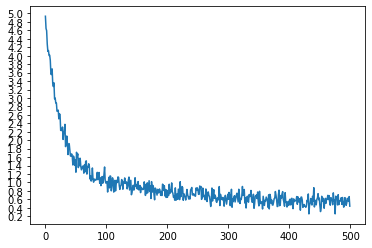

In [87]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 50000, print_every=3000, learning_rate=0.01)

In [96]:
test_pairs = [[s,  t]for s, t in list(zip(test_df.drop_duplicates().src, test_df.drop_duplicates().tgt))]
evaluateRandomly(encoder1, attn_decoder1, test_pairs)

> i want to know how hot it is in neumarkt from five twenty eight to fifteen seventeen
= i want to know how hot it is in neumarkt from 05:28 to 15:17
< i want to know how hot it is in neumarkt <EOS>

> i want to know how warm it is in munstertal black forest from twenty nine minutes past midnight to fifteen twenty
= i want to know how warm it is in munstertal black forest from 00:29 to 15:20
< i want to know how warm it is in tremezzo from 13:20 to 20:18 <EOS>

> is it going to be hot in constance on nineteenth july
= is it going to be hot in constance on 19.7
< is it going to be hot in constance on 19.12 <EOS>

> turn on pointless
= turn on pointless
< turn on cams <EOS>

> i would like to watch tele zentralschweiz
= i would like to watch tele zentralschweiz
< i would like to watch canal plus <EOS>

> do i need a coat on wednesday
= do i need a coat on wednesday
< do i need a coat on wednesday <EOS>

> i would like to know if it is raining in algund on twentieth december
= i would lik

In [88]:
# evaluate in validation set
from jiwer import wer
from tqdm import tqdm 

def evaluateWER(encoder, decoder, n=10):
    WER = 0
    size = 0
    for test_pair in tqdm(test_pairs):
        try:
            output_words, attentions = evaluate(encoder, decoder, test_pair[0])
            output_sentence = ' '.join(output_words[:-1])
            WER += wer(test_pair[1], output_sentence)
            size += 1
        except:
            pass
    print("WER: {}".format(WER/ size))
        
wer_base = wer(test_df.drop_duplicates().src.tolist(), test_df.drop_duplicates().tgt.tolist())
print("WER_base: {}".format(wer_base))
evaluateWER(encoder1, attn_decoder1)

  0%|          | 7/4117 [00:00<01:03, 64.31it/s]

WER_base: 0.2059035277177826


100%|██████████| 4117/4117 [00:56<00:00, 72.91it/s] 

WER: 0.2007957888790723


input = is it going to be nice outside at seventeen fifteen in milan
output = is it going to be nice outside at 17:15 in milan <EOS>


<ipython-input-97-8aeba70aa22f>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-97-8aeba70aa22f>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


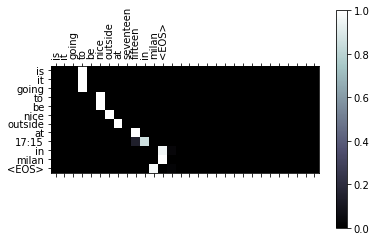

input = tell me something about real betis sevilla
output = tell me something about real cf cf <EOS>


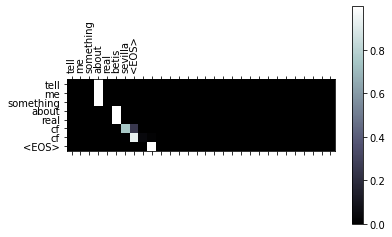

input = is it raining on fifteenth september
output = is it raining on 15.9 <EOS>


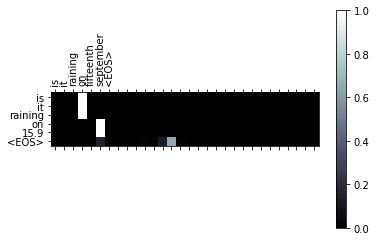

input = four hundred and twenty eight
output = rainfall <EOS>


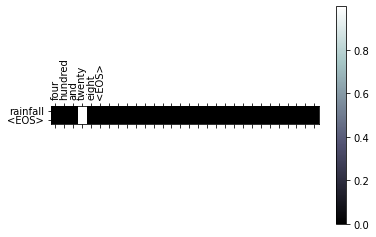

input = is it raining in plateau from seven twenty five to three fifteen
output = is it raining in zurich from 05:28 to 07:33 <EOS>


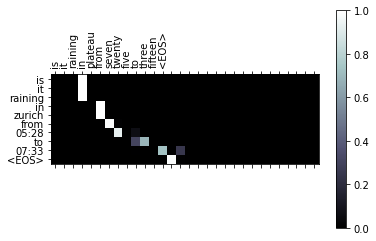

In [97]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    
evaluateAndShowAttention("is it going to be nice outside at seventeen fifteen in milan")
evaluateAndShowAttention("tell me something about real betis sevilla")
evaluateAndShowAttention("is it raining on fifteenth september")
evaluateAndShowAttention("four hundred and twenty eight")
evaluateAndShowAttention("is it raining in plateau from seven twenty five to three fifteen")

## GloVe

In [98]:
import bcolz
import pickle
# words = []
# idx = 0
# word2idx = {}
glove_path = "/home/zhechensu/glove/glove.6B.50d.txt"
rootdir = f'/home/zhechensu/glove/glove.6B/'
# vectors = bcolz.carray(np.zeros(1), rootdir=rootdir + '6B.50.dat', mode='w')

# with open(glove_path, 'rb') as f:
#     for l in f:
#         line = l.decode().split()
#         word = line[0]
#         words.append(word)
#         word2idx[word] = idx
#         idx += 1
#         vect = np.array(line[1:]).astype(np.float)
#         vectors.append(vect)
     
# vectors = bcolz.carray(vectors[1:].reshape((400000, 50)), rootdir= rootdir + '6B.50.dat', mode='w')
# vectors.flush()
# pickle.dump(words, open(rootdir + '6B.50_words.pkl', 'wb'))
# pickle.dump(word2idx, open(rootdir + '6B.50_idx.pkl', 'wb'))

In [99]:
# Load Glove Vectors
vectors = bcolz.open(rootdir + '6B.50.dat')[:]
words = pickle.load(open(rootdir + '6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(rootdir + '6B.50_idx.pkl', 'rb'))
 
glove = {w: vectors[word2idx[w]] for w in words}

In [101]:
# for moving 'sos' token at index 0 and 'eos' token at index 1

sos_index = word2idx['sos']
eos_index = word2idx['eos']
sos_swap_word = words[0]
eos_swap_word = words[1]
 
words[0], words[sos_index] = words[sos_index], words[0]
words[1], words[eos_index] = words[eos_index], words[1]
word2idx[sos_swap_word], word2idx['sos'] = word2idx['sos'], word2idx[sos_swap_word]
word2idx[eos_swap_word], word2idx['eos'] = word2idx['eos'], word2idx[eos_swap_word]


In [102]:
# Sort word2idx
import operator
word2idx = { k : v for k , v in sorted(word2idx.items(), key=operator.itemgetter(1))}


In [103]:
class LangGlove:
    def __init__(self, name):
        self.name = name
        self.word2index = { k : v for k , v in sorted(word2idx.items(), key=operator.itemgetter(1))}
        self.word2count = { word : 1 for word in words }
        self.index2word = { i : word for word, i in word2idx.items() }
        self.n_words = 400001
 
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
 
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [104]:
input_lang, output_lang, pairs = prepareData(train_df.src.tolist(), train_df.tgt.tolist(), LangGlove)
print(random.choice(pairs))

Reading lines...
Read 256719 sentence pairs
Counting words...
Counted words:
src 401042
tgt 401224
['change to radio channel eighty one please', 'change to radio channel 81 please']


17m 5s (- 324m 40s) (3000 5%) 3.9955
34m 38s (- 311m 48s) (6000 10%) 2.1684
52m 37s (- 298m 12s) (9000 15%) 1.4947
70m 44s (- 282m 56s) (12000 20%) 1.2769
88m 55s (- 266m 46s) (15000 25%) 1.1928
107m 9s (- 250m 2s) (18000 30%) 1.0972
125m 14s (- 232m 35s) (21000 35%) 1.0247
143m 23s (- 215m 5s) (24000 40%) 0.9148
161m 32s (- 197m 26s) (27000 45%) 0.8787
179m 34s (- 179m 34s) (30000 50%) 0.8311
197m 43s (- 161m 46s) (33000 55%) 0.8255
215m 57s (- 143m 58s) (36000 60%) 0.7747
234m 21s (- 126m 11s) (39000 65%) 0.7270
252m 39s (- 108m 16s) (42000 70%) 0.6609
270m 40s (- 90m 13s) (45000 75%) 0.6204
288m 34s (- 72m 8s) (48000 80%) 0.6255
306m 40s (- 54m 7s) (51000 85%) 0.5919
324m 44s (- 36m 4s) (54000 90%) 0.5607
342m 53s (- 18m 2s) (57000 95%) 0.5606
361m 16s (- 0m 0s) (60000 100%) 0.5413


<Figure size 432x288 with 0 Axes>

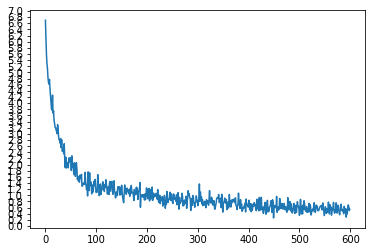

In [105]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 60000, print_every=3000, learning_rate=0.01)

In [106]:
evaluateWER(encoder1, attn_decoder1)

100%|██████████| 4117/4117 [03:57<00:00, 17.36it/s]

WER: 0.1835954084369874


In [110]:
evaluateRandomly(encoder1, attn_decoder1, test_pairs)

> how much rain can i expect in constance on seventh june
= how much rain can i expect in constance on 7.6
< how much rain can i expect in constance on 3.6 <EOS>

> can you please switch the device hue ambiance ceiling one on
= can you please switch the device hue ambiance ceiling 1 on
< can you please switch the device hue ambiance candle 1 on <EOS>

> weather news for one fifty in latsch
= weather news for 01:50 in latsch
< weather news for 01:50 in latsch <EOS>

> i want to know how hot it is in neumarkt from five twenty eight to fifteen seventeen
= i want to know how hot it is in neumarkt from 05:28 to 15:17
< i want to know how hot it is in neumarkt from 05:28 to 05:28 <EOS>

> turn on lamp in the bathroom
= turn on lamp in the bathroom
< turn on lamp in the bathroom <EOS>

> do you know how the weather is at fourteen oh five
= do you know how the weather is at 14:05
< do you know how the weather is at 14:05 <EOS>

> i need the temperature for eleven oh one in geneva
= i need the 

input = is it going to be nice outside at seventeen fifteen in milan
output = is it going to be nice outside at 17 : 15 in milan <EOS>


<ipython-input-38-54521568c49a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-38-54521568c49a>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


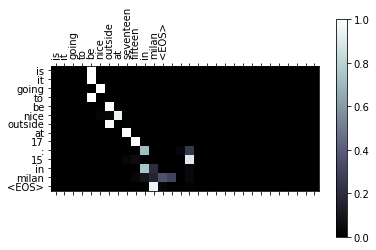

input = tell me something about real betis sevilla
output = tell me something about patrick j <EOS>


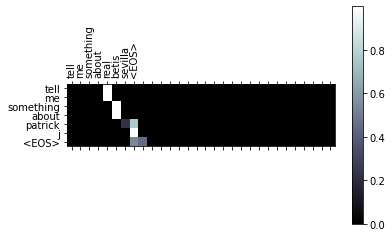

input = is it raining on fifteenth september
output = is it raining on 15 . 9 <EOS>


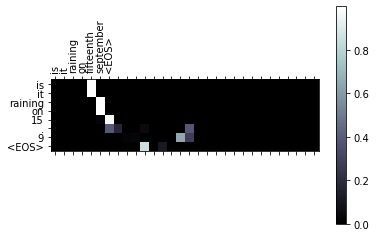

input = four hundred and twenty eight
output = 28 <EOS>


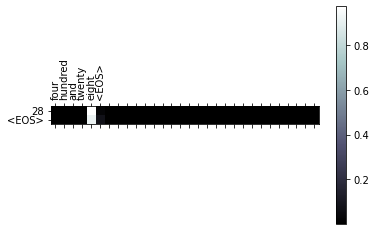

input = is it raining in plateau from seven twenty five to three fifteen
output = is it raining in plateau from 15 : 52 to 03 : 15 <EOS>


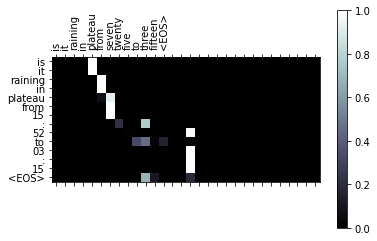

In [38]:
import torch.nn.functional as F
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    
evaluateAndShowAttention("is it going to be nice outside at seventeen fifteen in milan")
evaluateAndShowAttention("tell me something about real betis sevilla")
evaluateAndShowAttention("is it raining on fifteenth september")
evaluateAndShowAttention("four hundred and twenty eight")
evaluateAndShowAttention("is it raining in plateau from seven twenty five to three fifteen")
# evaluateAndShowAttention("i am looking for star wars  revenge of the sit")

In [111]:
import pickle
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename
 
def load_variable(filename):
    f=open(filename,'rb')
    r=pickle.load(f)
    f.close()
    return r

save_variable(encoder1, 'models/s2s_250k+glove_encoder.pkl') 
save_variable(attn_decoder1, 'models/s2s_250k+glove_decoder.pkl') 

'models/s2s_250k+glove_decoder.pkl'

Evaluation for 70K model

In [23]:
name = '60k+1k+glove' #{'70k', '60k+1k', '60k+1k+glove'}
encoder1 = load_variable('models/s2s_{}_encoder.pkl'.format(name))
attn_decoder1 = load_variable('models/s2s_{}_decoder.pkl'.format(name))
# evaluateRandomly(a, b)